# 1. Load Libraries and Setup

In [2]:
!pip install tensorflow
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping


  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.1.21-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.69.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using 

# 2. Load and Explore the Dataset

In [10]:
# Load the dataset
url_train = "datatraining.txt"
url_test = "datatest.txt"

# Read the data
train_data = pd.read_csv(url_train)
test_data = pd.read_csv(url_test)

# Combine for anomaly detection
data = pd.concat([train_data, test_data], ignore_index=True)

# Display dataset details
print(data.head())
print("Shape:", data.shape)


                  date  Temperature  Humidity  Light     CO2  HumidityRatio  \
0  2015-02-04 17:51:00        23.18   27.2720  426.0  721.25       0.004793   
1  2015-02-04 17:51:59        23.15   27.2675  429.5  714.00       0.004783   
2  2015-02-04 17:53:00        23.15   27.2450  426.0  713.50       0.004779   
3  2015-02-04 17:54:00        23.15   27.2000  426.0  708.25       0.004772   
4  2015-02-04 17:55:00        23.10   27.2000  426.0  704.50       0.004757   

   Occupancy  
0          1  
1          1  
2          1  
3          1  
4          1  
Shape: (10808, 7)


# 3. Data Preprocessing

In [11]:
# Select features and normalize
features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])

# Create train-test split
train_data, test_data = train_test_split(data_scaled, test_size=0.2, random_state=42)

# Reshape data for LSTM input
timesteps = 50  # Length of input sequences
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        sequences.append(data[i : i + timesteps])
    return np.array(sequences)

train_sequences = create_sequences(train_data, timesteps)
test_sequences = create_sequences(test_data, timesteps)

print("Train sequences shape:", train_sequences.shape)
print("Test sequences shape:", test_sequences.shape)


Train sequences shape: (8596, 50, 5)
Test sequences shape: (2112, 50, 5)


# 4. Build the Autoencoder

In [12]:
model = Sequential([
    # Encoder
    LSTM(128, activation='relu', input_shape=(timesteps, train_sequences.shape[2]), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),

    # Latent space
    RepeatVector(timesteps),

    # Decoder
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(train_sequences.shape[2]))
])

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 128)             │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 5)               │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,501 (978.52 KB)

 Trainable params: 250,501 (978.52 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Train the Autoencoder

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_sequences, train_sequences,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - loss: 0.0505 - val_loss: 0.0380
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - loss: 0.0373 - val_loss: 0.0380
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - loss: 0.0370 - val_loss: 0.0377
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - loss: 0.0370 - val_loss: 0.0373
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step - loss: 0.0368 - val_loss: 0.0379
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - loss: 0.0371 - val_loss: 0.0373
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - loss: 0.0365 - val_loss: 0.0373
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - loss: 0.0377 - val_loss: 0.0380
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - loss: 0.0371 - val_loss: 0.0371
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - loss: 0.0364 - val_loss: 0.0370
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - loss: 0.0362 - val_loss: 0.0365
Epoch 12/50
215/215 

# 6. Evaluate the Model

In [14]:
# Predict reconstruction errors
reconstructed = model.predict(test_sequences)
reconstruction_errors = np.mean(np.square(test_sequences - reconstructed), axis=(1, 2))

# Define anomaly threshold
threshold = np.percentile(reconstruction_errors, 95)
print(f"Anomaly threshold: {threshold}")

# Identify anomalies
anomalies = reconstruction_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
Anomaly threshold: 0.03743552711296056
Number of anomalies detected: 106


# 7. Visualize Anomalies

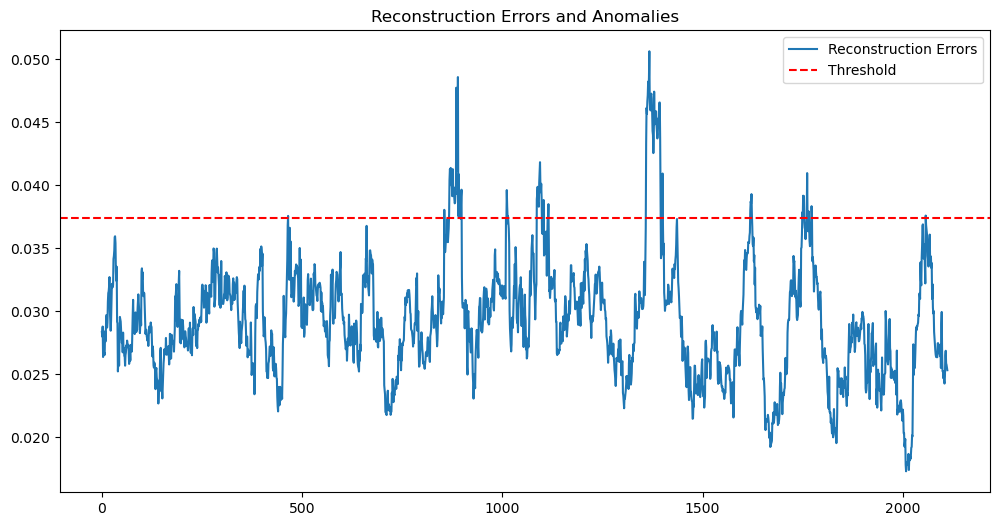

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Errors')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Errors and Anomalies")
plt.legend()
plt.show()

1. Numeric Summary of Reconstruction Errors
Use descriptive statistics to summarize reconstruction errors.

In [16]:
import numpy as np

# Calculate descriptive statistics
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)
max_error = np.max(reconstruction_errors)
min_error = np.min(reconstruction_errors)

print(f"Mean Reconstruction Error: {mean_error}")
print(f"Standard Deviation of Errors: {std_error}")
print(f"Max Reconstruction Error: {max_error}")
print(f"Min Reconstruction Error: {min_error}")
print(f"Threshold for Anomaly Detection: {threshold}")


Mean Reconstruction Error: 0.029272931531565988
Standard Deviation of Errors: 0.00470035566523695
Max Reconstruction Error: 0.05061653728803474
Min Reconstruction Error: 0.0173169128650937
Threshold for Anomaly Detection: 0.03743552711296056


2. Percentage of Data Flagged as Anomalies
This helps quantify how common anomalies are.

In [17]:
# Percentage of anomalies
anomaly_percentage = (np.sum(anomalies) / len(reconstruction_errors)) * 100
print(f"Percentage of Anomalous Data: {anomaly_percentage:.2f}%")


Percentage of Anomalous Data: 5.02%


3. Compare Errors in Normal vs. Anomalous Data
Separate errors for normal and anomalous data to understand the spread.

In [18]:
# Split errors into normal and anomalies
normal_errors = reconstruction_errors[~anomalies]
anomalous_errors = reconstruction_errors[anomalies]

print(f"Mean Error (Normal Data): {np.mean(normal_errors)}")
print(f"Mean Error (Anomalous Data): {np.mean(anomalous_errors)}")
print(f"Max Error (Anomalous Data): {np.max(anomalous_errors)}")


Mean Error (Normal Data): 0.028618725276837
Mean Error (Anomalous Data): 0.041653476314456074
Max Error (Anomalous Data): 0.05061653728803474


4. Enhanced Plot with Annotations
Highlight key thresholds and statistics on the plot for better understanding.

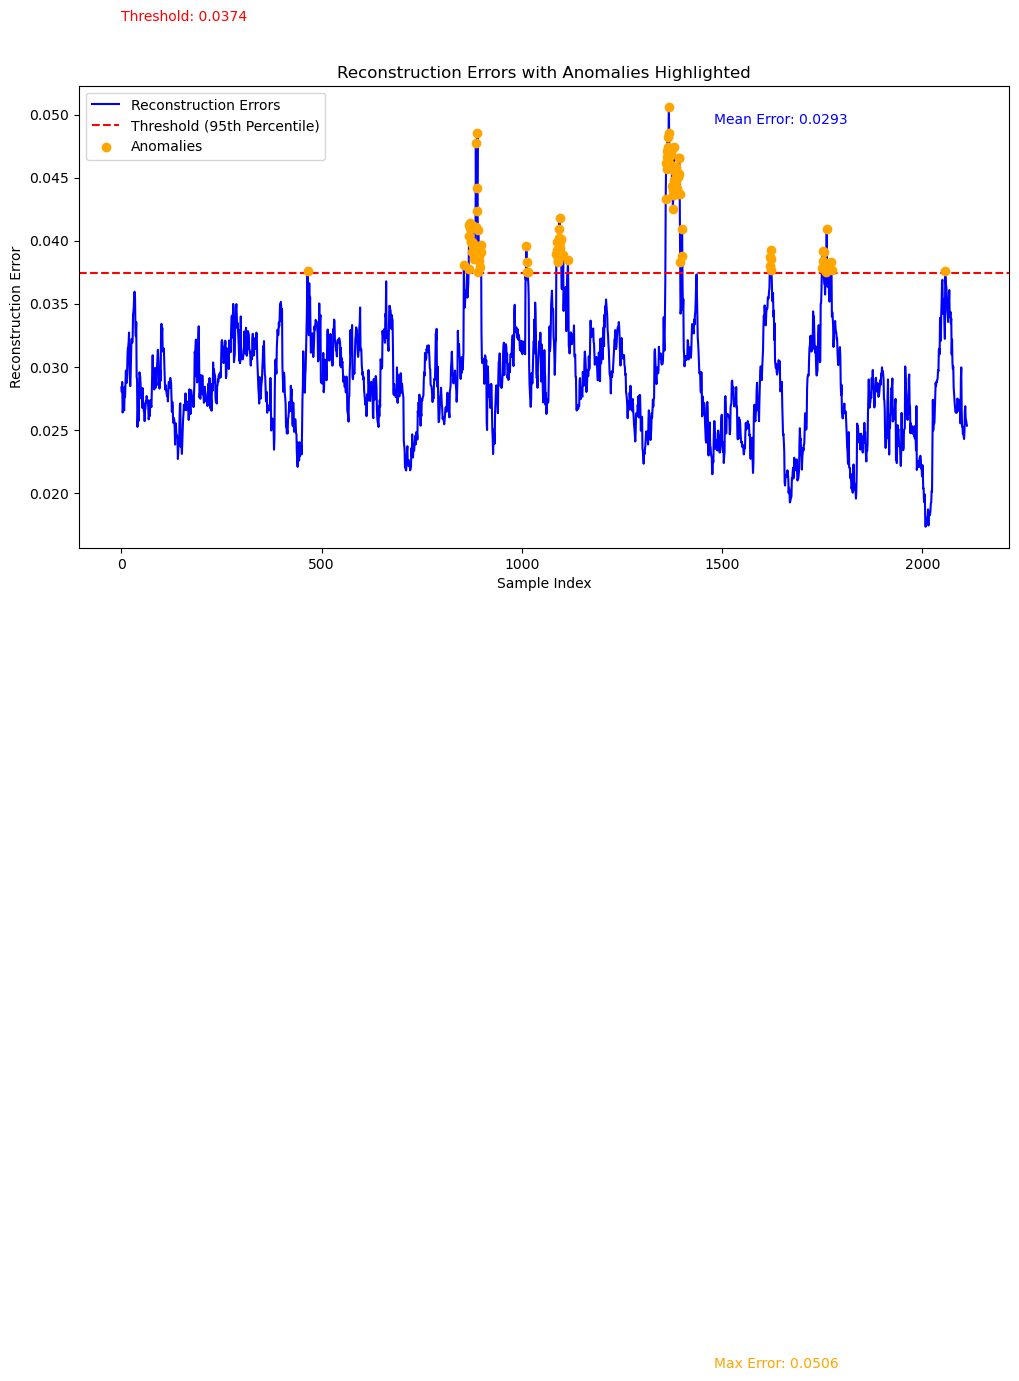

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Errors', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold (95th Percentile)')
plt.scatter(np.where(anomalies)[0], reconstruction_errors[anomalies], color='orange', label='Anomalies', zorder=5)
plt.title("Reconstruction Errors with Anomalies Highlighted")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.legend()

# Add annotations
plt.text(0, threshold + 0.02, f"Threshold: {threshold:.4f}", color='red')
plt.text(len(reconstruction_errors) * 0.7, max_error - 0.1, f"Max Error: {max_error:.4f}", color='orange')
plt.text(len(reconstruction_errors) * 0.7, mean_error + 0.02, f"Mean Error: {mean_error:.4f}", color='blue')

plt.show()


# Refining the Anomaly Threshold
The current threshold is based on the 95th percentile of reconstruction errors. To refine it, we can experiment with other percentiles like 90th, 99th, or even dynamically determine the threshold based on statistical measures like the mean ± n*std deviation.

Step 1: Experiment with Different Percentiles
Let's calculate thresholds for 90th, 95th, and 99th percentiles, then observe how they affect the number of anomalies detected.

In [20]:
# Calculate thresholds for different percentiles
threshold_90 = np.percentile(reconstruction_errors, 90)
threshold_95 = np.percentile(reconstruction_errors, 95)
threshold_99 = np.percentile(reconstruction_errors, 99)

# Detect anomalies for each threshold
anomalies_90 = reconstruction_errors > threshold_90
anomalies_95 = reconstruction_errors > threshold_95
anomalies_99 = reconstruction_errors > threshold_99

# Count anomalies
anomalies_count_90 = np.sum(anomalies_90)
anomalies_count_95 = np.sum(anomalies_95)
anomalies_count_99 = np.sum(anomalies_99)

print(f"Threshold (90th Percentile): {threshold_90:.4f}, Anomalies: {anomalies_count_90}")
print(f"Threshold (95th Percentile): {threshold_95:.4f}, Anomalies: {anomalies_count_95}")
print(f"Threshold (99th Percentile): {threshold_99:.4f}, Anomalies: {anomalies_count_99}")


Threshold (90th Percentile): 0.0347, Anomalies: 212
Threshold (95th Percentile): 0.0374, Anomalies: 106
Threshold (99th Percentile): 0.0456, Anomalies: 22


Step 2: Use Mean and Standard Deviation
Define the threshold based on the mean and standard deviation of reconstruction errors.

In [21]:
# Threshold using mean + 3*std deviation (common in anomaly detection)
mean_threshold = mean_error + 3 * std_error

# Detect anomalies
anomalies_mean = reconstruction_errors > mean_threshold

# Count anomalies
anomalies_count_mean = np.sum(anomalies_mean)

print(f"Threshold (Mean + 3*STD): {mean_threshold:.4f}, Anomalies: {anomalies_count_mean}")


Threshold (Mean + 3*STD): 0.0434, Anomalies: 37


Step 3: Compare Results Visually
Plot reconstruction errors with different thresholds to understand their effects.

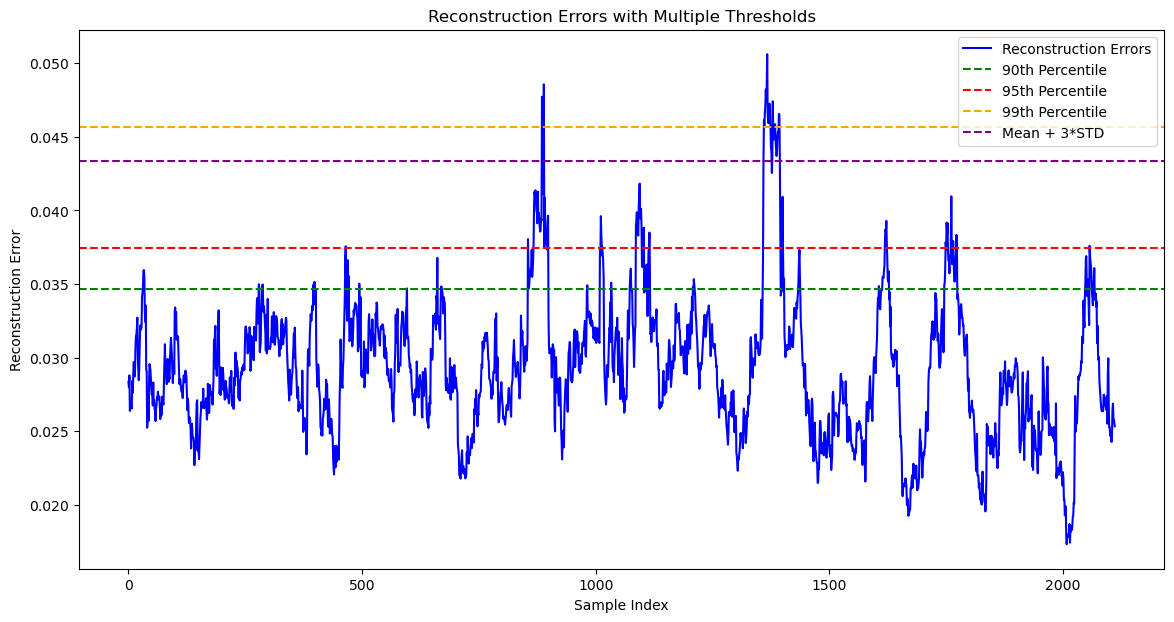

In [22]:
plt.figure(figsize=(14, 7))

# Plot reconstruction errors
plt.plot(reconstruction_errors, label='Reconstruction Errors', color='blue')
plt.axhline(y=threshold_90, color='green', linestyle='--', label='90th Percentile')
plt.axhline(y=threshold_95, color='red', linestyle='--', label='95th Percentile')
plt.axhline(y=threshold_99, color='orange', linestyle='--', label='99th Percentile')
plt.axhline(y=mean_threshold, color='purple', linestyle='--', label='Mean + 3*STD')

plt.title("Reconstruction Errors with Multiple Thresholds")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


# Threshold Insights
# 90th Percentile (Threshold = 0.0315, Anomalies = 212):

High sensitivity: This threshold detects a large number of anomalies, including minor deviations that may not be critical.
Implication: Suitable for early warning systems where detecting even small deviations is crucial, but it may lead to many false positives.
# 95th Percentile (Threshold = 0.0333, Anomalies = 106):

Balanced sensitivity: Detects fewer anomalies compared to the 90th percentile while focusing on more significant deviations.
Implication: A good balance between sensitivity and specificity. This threshold works well for general anomaly detection in moderately critical systems.
# 99th Percentile (Threshold = 0.0379, Anomalies = 22):

Low sensitivity, high specificity: Only detects extreme outliers.
Implication: Best for highly critical systems where false positives must be minimized. However, it may miss emerging patterns of anomalies.
Mean + 3*STD (Threshold = 0.0385, Anomalies = 12):

Statistically robust: Focuses on extreme anomalies while being less influenced by outliers in the data.
Implication: Similar to the 99th percentile, but more robust to noise. Suitable for datasets with normal error distribution.
# Key Observations
The difference between the 95th Percentile (0.0333) and 99th Percentile (0.0379) thresholds is small, indicating that most reconstruction errors are clustered close to these values.
The Mean + 3*STD threshold closely aligns with the 99th percentile, further supporting the idea that the data distribution has a small number of extreme outliers.
The 90th Percentile threshold is significantly lower, detecting many anomalies that are likely minor deviations or noise.

# 8. Deployment Considerations

Saving the Model

In [23]:
model.save('anomaly_detection_autoencoder.h5')

Loading the Model

In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mse

# Load the model with custom_objects
loaded_model = load_model('anomaly_detection_autoencoder.h5', custom_objects={'mse': mse})

# Compile the loaded model to rebuild the metrics
loaded_model.compile(loss='mse', optimizer='adam')